<a href="https://colab.research.google.com/github/TrynowPht/DataSetSARS/blob/master/_TF_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TRABAJO FINAL**
**MACHINE LEARNING**
2020-2



Integrantes:
*   Piero Herrera
*   Camilo Silva
*   Diego Urrutia


## Caso de Estudio – Diagnosticando de SARS-COV-2


## **Introducción**

El dataset con el que no encontramos es un conjunto de imágenes de tomografía computarizada de SARS-CoV-2 disponible para el público. Este data set contiene 1252 tomografías computarizadas que son positivas para la infección por SARS-CoV-2 (COVID-19) y 1230 tomografías computarizadas para pacientes no infectados por SARS-CoV-2, 2482 Tomografías computarizadas en total. Los datos son reales, basadons en al recopilación de los resultados de pacientes en los hospitales en Sao Paulo, Brasil. Los creadores del data set mencionan que el objetivo de esta data es fomentar la investigación y desarrollo de métodos de IA con el fin de identificar si una persona está infectada po el SARS-COV-2 mediantes el análisis de tomografías computarizadas. El conjunto de datos propuesto está disponible en www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset

Metodología:

1. Descargar dataset con las 2482 tomografías computarizadas
2. Realizar la lectura de la imágenes. (Conversión a numpy.array)
3. Aplicación de *SIFT*, *SURF* y *ORB* para obtener los vectores caracterísitcos de las imágenes del dataset.
4. Uso de *Bag of Words* (BoW) con el fin de reducir cada imagen en un vector característico de esta. Se generará dos dataframes como resultado del uso de BoW en los vectores característicos obtenidos en SIFT, SURF y ORB
5. Estandarizaciós de los datasets de vectores característicos reducidos
6. Aplicación de PCA
7. Se dividirá la data total en una parte de entrenamiento y test. Para la clasificación se han elegido 5 modelos clasificadores: Gaussian Naive Bayes, Multinomial Naive Bayes, Support Vector Machine, Random Forest y Nearest neighbor
4. Aplicados los modelos se realiza la validación correspondiente y la comparación de resultados obtenidos


### Importación de Librerías

Se realiza una instalación de una versión anterior de opencv, debido a que versiones actuales no permiten realizar el computo de keypoints de SIFT y SURF.

In [1]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 154kB/s 
     |████████████████████████████████| 14.5MB 270kB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:


In [2]:
import time
import random
import os as os
import cv2 as cv
import numpy as np
import pandas as pd
import requests, zipfile, io
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
#Pruebas
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


#Clasificadores
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#Pruebas
from sklearn.ensemble import VotingClassifier

#Metricas
from sklearn import metrics
from keras.models import Sequential
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score

### Lectura de la data y asignación de clases

Descarga del dataset del link de origen

In [3]:
url = "https://slothnetwork.com/covid.zip"
local_folder = "/content/dataImages"

# Enviando request para obtener el archivo comprimido con las imagenes
response = requests.get(url)

# Extrayendo archivo comprimido en el entorno local
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall(local_folder)

Creación de un diccionario para identificar de mejor manera las clases

In [4]:
lesion_types_pre = {'COVID': 1, 'non-COVID': 0}

Resize de imágenes

In [5]:
cols = ['img', 'class']

# Nuevas medidas para cada una de las imagenes (Resize)
img_width = 320
img_height = 240

df = pd.DataFrame(columns = cols)

# Recorriendo los directorios de las imagenes y generando el dataframe
for target in lesion_types_pre.keys():
  file_path = "/content/dataImages/"+target
  for image_path in os.listdir(file_path):
     image = cv.imread(file_path + "/" + image_path, cv.IMREAD_COLOR)
     image_resize = cv.resize(image, (img_width, img_height))
     df = df.append({'img': image_resize, 'class': lesion_types_pre[target]}, ignore_index=True)

df.groupby('class').count()

,img
class,
0,1229
1,1252


Podemos apreciar la cantidad de imágenes que hay por clase

**Muestra Previa de imagenes y respectiva clase**

<Figure size 432x288 with 0 Axes>

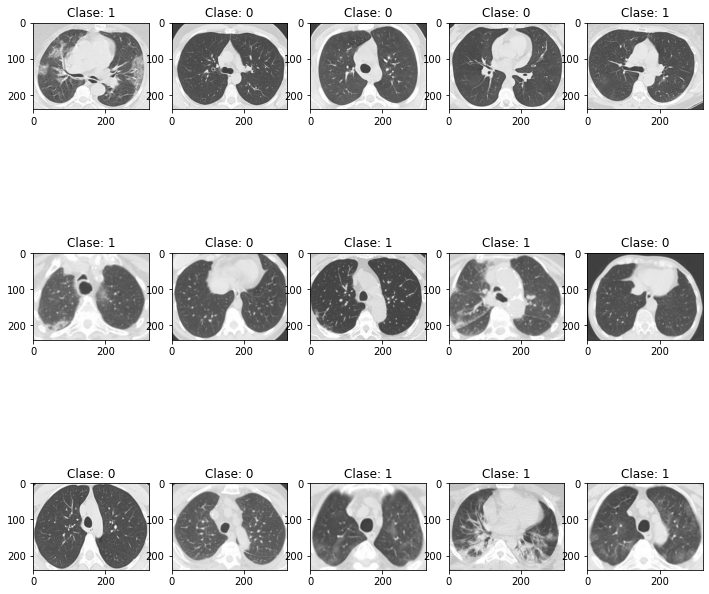

In [6]:
plt.figure()

f, axarr = plt.subplots(3,5, figsize=(12,12)) 

for i in range(0, 3):
  for j in range(0, 5):
    item_index =random.randint(0,df.shape[0])
    axarr[i][j].imshow(df.iloc[item_index]['img'])
    axarr[i][j].set_title("Clase: " + str(df.iloc[item_index]['class']))
plt.show()

#### Aplicación de SIFT

Sift es un algoritmo que permite detectar y describir características locales en imágenes. Para ello se sigue una serie de pasos:
1. **Selección de picos de espacio de escala**: ubicación potencial para encontrar 
entidades.
2. **Localización de puntos clave** : localización precisa de los puntos clave de funciones.
3. **Asignación de orientación**: asignación de orientación a puntos clave.
4. **Descriptor de puntos clave** : describe los puntos clave como un vector.
5. **Coincidencia de puntos clave**

Dimensiones:  (490, 128)


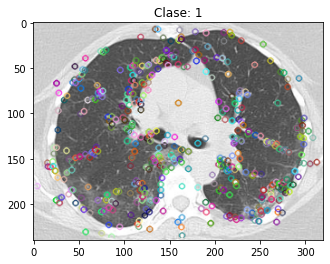

In [7]:
sift = cv.xfeatures2d.SIFT_create()

# Funcion para extraer keypoints con SIFT dado una imagen
def extractKeypointsSift(img):
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  sift_kp, sift_des = sift.detectAndCompute(gray,None)
  return sift_kp, sift_des

random_index = random.randint(0,df.shape[0])
sift_test_img = df.iloc[random_index]['img']
sift_test_class = df.iloc[random_index]['class']

sift_test_keypoints, sift_test_descriptor = extractKeypointsSift(sift_test_img)

gray = cv.cvtColor(sift_test_img, cv.COLOR_BGR2GRAY)
img_sift_kp = cv.drawKeypoints(gray, sift_test_keypoints, None)

print("Dimensiones: ", sift_test_descriptor.shape)
plt.figure()
plt.title("Clase: "+ str(sift_test_class))
plt.imshow(img_sift_kp)
plt.show()

##### Extracción de Keypoints SIFT

In [8]:
start_time_sift = time.time()

# Vectores que almacenan los keypoints y sus descriptores
fSift = []

# Recorriendo cada entrada del dataframe y generando keypoints y descriptores
for i, row in df.iterrows():
  sift_img = extractKeypointsSift(row['img'])
  fSift.append(sift_img)

print("Keypoints SIFT extraidos en %s segundos"  % (time.time() - start_time_sift))

Keypoints SIFT extraidos en 96.05364751815796 segundos


#### Aplicación de SURF

SURF es un algoritmo para la representación y la comparación local de imágenes. De manera similar a otros métetodos también basados en descriptores locales, los *keyponits* de una imagen dada se definen como características sobresalientes de una representación invariante de escala. Dicho análisis se obtiene mediante la convolución de la imagen inicial con granos discretos a varias escalas (filtros de caja) seguido del uso de gradientes locales (intensidad y orientación).

Dimensiones:  (415, 64)


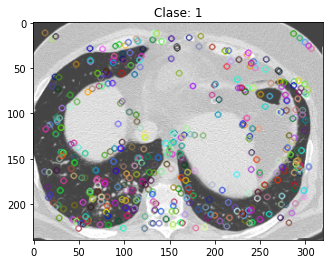

In [9]:
surf = cv.xfeatures2d.SURF_create()

# Funcion para extraer keypoints con SURF dado una imagen
def extractKeypointsSurf(img):
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  surf_kp, surf_des = surf.detectAndCompute(gray,None)
  return surf_kp, surf_des

random_index = random.randint(0,df.shape[0])
surf_test_img = df.iloc[random_index]['img']
surf_test_class = df.iloc[random_index]['class']

surf_test_keypoints, surf_test_descriptor = extractKeypointsSurf(surf_test_img)

gray = cv.cvtColor(surf_test_img, cv.COLOR_BGR2GRAY)
img_surf_kp = cv.drawKeypoints(gray, surf_test_keypoints, None)

print("Dimensiones: ", surf_test_descriptor.shape)
plt.figure()
plt.title("Clase: "+ str(surf_test_class))
plt.imshow(img_surf_kp)
plt.show()

##### Extracción de Keypoints SURF

In [10]:
start_time_surf = time.time()
# Vectores que almacenan los keypoints y sus descriptores
fSurf = []

# Recorriendo cada entrada del dataframe y generando keypoints y descriptores 
for i, row in df.iterrows():
  surf_img = extractKeypointsSurf(row['img'])
  fSurf.append(surf_img)

print("Keypoints SURF extraidos en %s segundos"  % (time.time() - start_time_surf))



Keypoints SURF extraidos en 178.54694414138794 segundos


#### Aplicación de ORB


Dimensiones:  (449, 32)


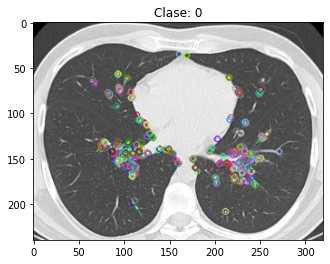

In [11]:
orb = cv.ORB_create()


# Funcion para extraer keypoints con SIFT dado una imagen
def extractKeypointsOrb(img):
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  orb_kp, orb_des = orb.detectAndCompute(gray,None)
  return orb_kp, orb_des

random_index = random.randint(0,df.shape[0])
orb_test_img = df.iloc[random_index]['img']
orb_test_class = df.iloc[random_index]['class']

orb_test_keypoints, orb_test_descriptor = extractKeypointsOrb(orb_test_img)

gray = cv.cvtColor(orb_test_img, cv.COLOR_BGR2GRAY)
img_orb_kp = cv.drawKeypoints(gray, orb_test_keypoints, None)

print("Dimensiones: ", orb_test_descriptor.shape)
plt.figure()
plt.title("Clase: "+ str(orb_test_class))
plt.imshow(img_orb_kp)
plt.show()

##### Extracción de Keypoints ORB

In [12]:
start_time_orb = time.time()

# Vectores que almacenan los keypoints y sus descriptores
fOrb = []

# Recorriendo cada entrada del dataframe y generando keypoints y descriptores
for i, row in df.iterrows():
  orb_img = extractKeypointsOrb(row['img'])
  fOrb.append(orb_img)

print("Keypoints Orb extraidos en %s segundos"  % (time.time() - start_time_orb))



Keypoints Orb extraidos en 11.910193920135498 segundos


### Bag of Words

Modelo para simplificar caraterísticas obtenidas

In [13]:
from sklearn.cluster import MiniBatchKMeans

def applyBow(fFile, df):

  start_time = time.time()

  # Vector que contendrá cada uno de los descriptores
  data = []

  # Recorremos toda la lista de keypoints
  for kp, kp_des in fFile:
    # Recorremos los descriptores de cada imagen
    for kpd in kp_des:
      # Los agregamos al vector
      data.append(kpd)

  # Inicializamos nuestro kmeans, con 50 clusters
  # y un batch size de 6000, y lo entrenamos para agrupar los descriptores
  kmeans = MiniBatchKMeans(n_clusters=20, verbose=0).fit(data)

  kmeans.verbose = False

  # Inicializando un vector que contendrá vectores
  # con cada uno de los histogramas de las imagenes
  features_hist = []
  for kp, kp_des in fFile:
    # Inicializando el histograma que cuantifica las ocurrencias
    # de cada uno de los clusters (50) en cada una de las imagenes
    hist = np.zeros(20)
    for kpd in kp_des:
      # Prediciendo el grupo al que pertenece
      # cada uno de los keypoints
      feature = kmeans.predict([kpd])
      hist[feature] += 1
    # Agregando el histograma de la imagen al
    # vector de histogramas
    features_hist.append(hist)
  
  print("BoW generado en %s segundos"  % (time.time() - start_time))

  # Agregando la clase a cada uno de los 
  # vectores de histograma
  for i, row in df.iterrows():
    features_hist[i] = np.append(features_hist[i], row['class'])

  # Generando un dataframe con los histogramas
  # y la clase de cada imagen como target
  cols = [ 'X'+str(i) for i in range(20) ]
  cols.append('class')

  df_bow = pd.DataFrame(data=features_hist, columns=cols)
  
  return df_bow


### Data Sets de Características resultantes

##### SURF

In [14]:
df_surf= applyBow(fSurf, df)

BoW generado en 560.6622898578644 segundos


In [15]:
df_surf.head(5)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,class
0,16.0,5.0,16.0,41.0,105.0,3.0,17.0,23.0,24.0,30.0,23.0,62.0,33.0,17.0,31.0,12.0,37.0,18.0,11.0,18.0,1.0
1,19.0,2.0,19.0,30.0,78.0,5.0,12.0,23.0,14.0,13.0,5.0,50.0,27.0,5.0,29.0,11.0,32.0,12.0,12.0,12.0,1.0
2,5.0,2.0,27.0,28.0,81.0,1.0,8.0,17.0,25.0,34.0,11.0,57.0,13.0,32.0,16.0,17.0,28.0,14.0,13.0,21.0,1.0
3,2.0,26.0,5.0,5.0,74.0,2.0,8.0,14.0,22.0,4.0,1.0,48.0,9.0,6.0,4.0,2.0,5.0,5.0,3.0,4.0,1.0
4,24.0,22.0,25.0,22.0,82.0,3.0,6.0,22.0,56.0,30.0,39.0,67.0,10.0,41.0,21.0,29.0,11.0,9.0,39.0,30.0,1.0


In [16]:
df_surf.shape

(2481, 21)

##### SIFT

In [17]:
df_sift = applyBow(fSift,df)

BoW generado en 446.3137867450714 segundos


In [18]:
df_sift.head(5)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,class
0,21.0,22.0,48.0,55.0,28.0,24.0,40.0,12.0,22.0,13.0,25.0,8.0,14.0,16.0,14.0,9.0,28.0,16.0,9.0,16.0,1.0
1,15.0,14.0,15.0,72.0,13.0,37.0,25.0,13.0,14.0,21.0,29.0,11.0,10.0,13.0,10.0,11.0,49.0,11.0,14.0,26.0,1.0
2,20.0,11.0,41.0,24.0,35.0,25.0,46.0,27.0,36.0,16.0,21.0,8.0,4.0,19.0,21.0,22.0,9.0,19.0,16.0,26.0,1.0
3,9.0,9.0,12.0,51.0,3.0,10.0,3.0,3.0,3.0,10.0,13.0,6.0,7.0,5.0,6.0,14.0,9.0,6.0,4.0,11.0,1.0
4,28.0,50.0,59.0,9.0,34.0,17.0,33.0,32.0,35.0,33.0,9.0,38.0,22.0,43.0,33.0,41.0,6.0,41.0,31.0,27.0,1.0


In [19]:
df_sift.shape

(2481, 21)

ORB

In [20]:
df_orb = applyBow(fOrb,df)

BoW generado en 522.7341330051422 segundos


In [21]:
df_orb.head(5)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,class
0,36.0,35.0,40.0,22.0,20.0,18.0,22.0,33.0,10.0,5.0,19.0,16.0,21.0,25.0,13.0,13.0,22.0,35.0,27.0,29.0,1.0
1,6.0,18.0,13.0,24.0,24.0,16.0,27.0,14.0,6.0,13.0,36.0,8.0,24.0,29.0,10.0,52.0,11.0,29.0,20.0,37.0,1.0
2,26.0,34.0,40.0,11.0,10.0,15.0,27.0,31.0,20.0,28.0,20.0,20.0,10.0,22.0,21.0,24.0,21.0,27.0,14.0,22.0,1.0
3,7.0,12.0,11.0,21.0,8.0,7.0,8.0,22.0,8.0,11.0,15.0,11.0,8.0,13.0,2.0,12.0,12.0,7.0,12.0,10.0,1.0
4,18.0,35.0,28.0,10.0,21.0,7.0,38.0,34.0,12.0,18.0,10.0,33.0,9.0,23.0,43.0,10.0,26.0,14.0,26.0,16.0,1.0


In [22]:
df_orb.shape

(2481, 21)

### Dataset de Entrenamieto y Test

Para las pruebas individuales realizamos la división del data frame total. Un 40% de la data sirvió para el entrenamiento y el 60% se usó como test.

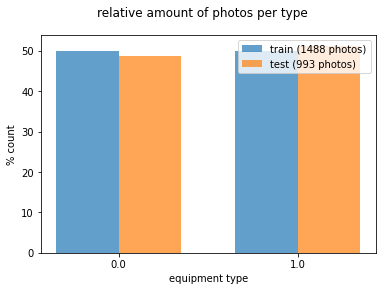

In [24]:
#@title División de la data
##Esto lo pasamos arriba
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
 
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
 
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
 
    xtemp = np.arange(len(unique))
 
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train_Surf, loc='left')
plot_bar(y_test_Surf, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train_Surf)),
    'test ({0} photos)'.format(len(y_test_Surf))
]);

Surf

In [77]:
X_Surf = df_surf[[x for x in df_surf.columns if x != 'class']]
y_Surf = df_surf['class']

scaler = StandardScaler()
X_Surf = pd.DataFrame(scaler.fit_transform(X_Surf), columns=X_Surf.columns)
#Test
#X_train_Surf, X_test_Surf, y_train_Surf, y_test_Surf = train_test_split(X_Surf, y_Surf, random_state = 10,shuffle=True,test_size = 0.4)

X_Surf

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19
0,-0.264711,-0.246984,-0.204749,1.818616,0.683601,-0.633006,0.749215,-0.162176,0.173139,0.340624,0.981571,0.163840,1.125106,0.255615,1.024293,-0.276038,1.189783,0.225990,-0.425491,0.381821
1,0.032550,-0.571944,0.222127,0.697423,-0.215417,-0.118176,0.049944,-0.162176,-0.609726,-0.645543,-1.049896,-0.462247,0.615124,-1.067665,0.839788,-0.429730,0.811544,-0.495916,-0.317020,-0.529188
2,-1.354668,-0.571944,1.360461,0.493570,-0.115526,-1.147835,-0.509473,-0.968509,0.251425,0.572663,-0.372740,-0.097030,-0.574835,1.909716,-0.359490,0.492421,0.508953,-0.255281,-0.208548,0.837326
3,-1.651929,2.027739,-1.769958,-1.850743,-0.348605,-0.890420,-0.509473,-1.371675,0.016566,-1.167632,-1.501333,-0.566595,-0.914823,-0.957391,-1.466516,-1.812957,-1.230946,-1.338139,-1.293262,-1.743867
4,0.527985,1.594459,1.075877,-0.117990,-0.082229,-0.633006,-0.789182,-0.296565,2.678306,0.340624,2.787318,0.424710,-0.829826,2.902176,0.101771,2.336724,-0.777059,-0.856869,2.611707,2.203839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2476,-0.561972,-0.680264,-0.204749,0.085863,-0.182120,-1.147835,-0.089910,-1.774841,-0.688012,1.558830,-0.034163,-0.514421,-0.404841,-0.295751,-0.359490,1.107189,-0.625763,-0.375599,0.225337,-0.529188
2477,-1.255581,0.294617,-1.058499,-1.443036,-0.248714,-0.890420,-0.929036,-0.834120,-0.296580,-0.819573,0.304415,1.259493,-0.319844,0.035069,-1.466516,-0.122346,-0.777059,-0.616234,-0.533962,-1.136528
2478,-0.462885,-0.788585,-0.489332,0.391643,-0.015635,0.139238,0.189798,0.912933,-0.766299,-0.297484,-0.372740,-0.618769,0.955112,-0.736845,0.655284,-1.198190,0.130714,-0.014646,-0.859377,-1.288363
2479,-0.760146,-0.680264,0.649002,0.289717,0.583710,0.396653,-0.509473,0.912933,-0.531439,1.674849,-0.034163,0.216014,1.295101,-0.957391,-0.451742,-0.122346,0.433305,0.707260,-0.100077,0.533656


In [92]:
from sklearn.decomposition import PCA
n_components = 10
pca = PCA(n_components)

X_Surf_PCA = pca.fit_transform(X_Surf)

X_Surf_PCA = pd.DataFrame(data = X_Surf_PCA
             , columns = [i+1 for i in range(n_components)])

finalDf = pd.concat([X_Surf_PCA, df_surf[['class']]], axis = 1)

X_train_Surf, X_test_Surf, y_train_Surf, y_test_Surf = train_test_split(X_Surf_PCA, y_Surf, random_state = 10,shuffle=True,test_size = 0.2)

finalDf

,1,2,3,4,5,6,7,8,9,10,class
0,-1.605469,1.454612,-0.341006,-0.303935,-0.939289,-0.338849,-0.607820,-0.185962,1.422760,1.038402,1.0
1,-1.511180,-0.738421,-0.227520,-0.785394,0.481381,-0.381478,0.753956,-0.660846,0.624181,0.001681,1.0
2,1.142964,0.212630,-1.548175,-0.365367,-1.467503,-0.435547,0.445596,-0.548866,-0.102250,0.899424,1.0
3,0.898025,-5.110503,2.376169,0.385637,-1.271744,0.071113,0.098085,0.268045,0.413131,-0.359083,1.0
4,5.126898,4.031080,0.009360,-0.034965,-1.273587,0.758916,-0.970971,0.244502,-0.021290,0.760197,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2476,0.450382,-0.754688,-0.991810,-0.905068,-1.784186,-1.213186,0.044616,0.383124,-1.108897,-0.090871,0.0
2477,1.246657,-2.526222,1.000247,1.019501,-0.746332,0.115866,-0.675597,-1.039276,-0.551877,0.447973,0.0
2478,-2.090040,-1.331047,-0.111980,-0.211861,0.961065,0.311537,0.176074,0.263575,0.769761,0.196614,0.0
2479,-1.589508,0.465630,-1.724544,0.773248,-0.416106,0.343531,0.729355,0.125401,-0.190011,-0.494327,0.0


shape of X_pca (2481, 5)
[0.29809171 0.21610737 0.09082922 0.07021383 0.05518198 0.03430169
 0.03223718 0.0279743  0.02397008 0.02054922]
suma: 0.8694565707486712


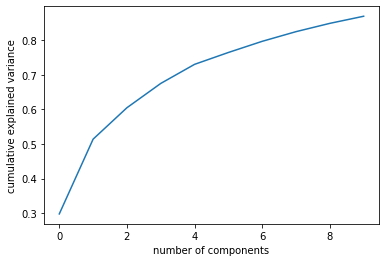

In [93]:
print("shape of X_pca", principalComponents.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:10]))
#Vemos que con 5 componentes tenemos algo mas del 75% de varianza explicada
 
#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(expl))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

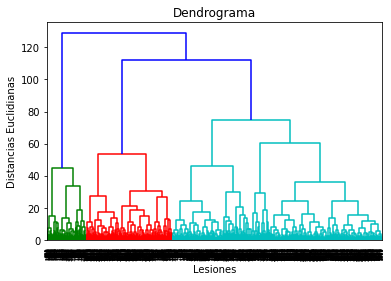

In [94]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(principalDf, method='ward'))
plt.title('Dendrograma')
plt.xlabel('Lesiones')
plt.ylabel('Distancias Euclidianas')
plt.show()

Sift

In [29]:
X_Sift = df_sift[[x for x in df_sift.columns if x != 'class']]
y_Sift = df_sift['class']

scaler = QuantileTransformer()
print(scaler)
X_Sift = pd.DataFrame(scaler.fit_transform(X_Sift), columns=X_Sift.columns)

X_train_Sift, X_test_Sift, y_train_Sift, y_test_Sift = train_test_split(X_Sift, y_Sift, random_state = 42,shuffle=True,test_size = 0.2)

QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='uniform', random_state=None,
                    subsample=100000)


Orb

In [30]:
X_Orb = df_orb [[x for x in df_orb.columns if x != 'class']]
y_Orb = df_orb['class']

scaler = QuantileTransformer()
X_Orb = pd.DataFrame(scaler.fit_transform(X_Orb), columns = X_Orb.columns)

X_train_Orb, X_test_Orb, y_train_Orb, y_test_Orb = train_test_split(X_Orb, y_Orb, random_state = 10,shuffle=True, test_size = 0.2)

**KFold**

En este caso usamos un numero de divisiones igual a 15 y activamos el parametro random_state para que estas divisiones sean aleatorias.

In [31]:
kfold = KFold(n_splits = 15, random_state = 10, shuffle= True)

### Modelos de Clasificación

Como mencionamos anteriormente, se eligieron 5 modelos de clasificación con el fin de encontrar el que nos devolvía mejores resultado en relación al **accuracy**

In [32]:
#@title ##### Función plot Matriz Gráfica
def showconfusionamtrix(cm):
  plt.matshow(cm)
  plt.colorbar()
  plt.show()

#### **Support Vector Machine (SVM)**

Es un modelo de **aprendizaje supervisado** que analizan los datos utilizados para realizar tanto clasificaciones como regresiones.

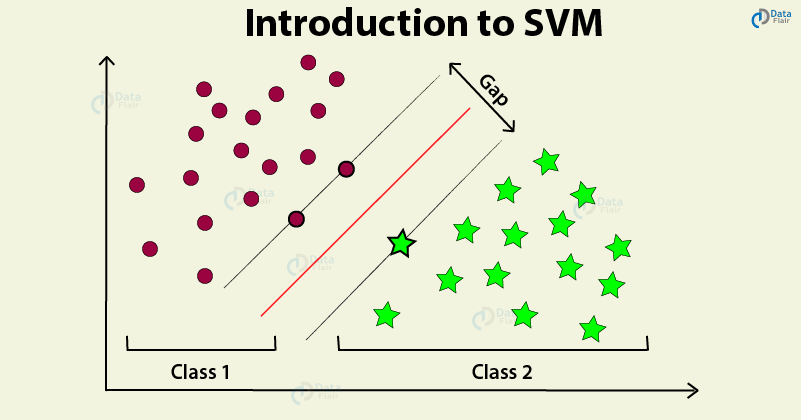

##### SURF

              precision    recall  f1-score   support

         0.0       0.80      0.89      0.85       484
         1.0       0.89      0.79      0.84       509

    accuracy                           0.84       993
   macro avg       0.85      0.84      0.84       993
weighted avg       0.85      0.84      0.84       993

Accuracy Calculado: 0.8418932527693856
F1 Calculado 0.8416551133724821
Accuracy CrossValidation: 0.8581209687233783 

MATRIZ DE CONFUSIÓN



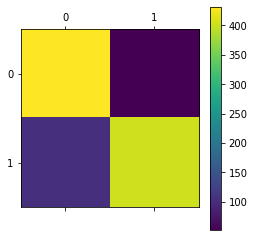

,0,1
0,432,52
1,105,404


In [33]:
SVM_Surf = svm.SVC(kernel='rbf') 

SVM_Surf.fit(X_train_Surf, y_train_Surf)

y_pred_Surf_SVM = SVM_Surf.predict(X_test_Surf)

print(metrics.classification_report(y_test_Surf, y_pred_Surf_SVM,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Surf, y_pred_Surf_SVM))
print("F1 Calculado", metrics.f1_score(y_test_Surf, y_pred_Surf_SVM,average= 'weighted'))
print("Accuracy CrossValidation:", cross_val_score(SVM_Surf, X_Surf, y_Surf, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SURF_SVM = confusion_matrix(y_test_Surf,y_pred_Surf_SVM)
DF_CM_SURF_SVM = pd.DataFrame(data = CM_SURF_SVM)

print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SURF_SVM)
DF_CM_SURF_SVM


##### SIFT

              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87       258
         1.0       0.89      0.82      0.85       239

    accuracy                           0.86       497
   macro avg       0.87      0.86      0.86       497
weighted avg       0.86      0.86      0.86       497

Accuracy Calculado: 0.8631790744466801
Accuracy CrossValidation: 0.862976755506876 

MATRIZ DE CONFUSIÓN



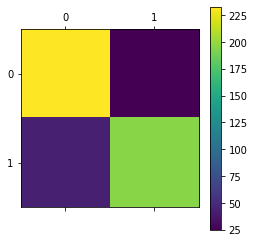

,0,1
0,233,25
1,43,196


In [34]:
SVM_Sift = svm.SVC(kernel='rbf') 

SVM_Sift.fit(X_train_Sift, y_train_Sift)

y_pred_Sift_SVM = SVM_Sift.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_SVM,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Sift, y_pred_Sift_SVM))
print("Accuracy CrossValidation:", cross_val_score(SVM_Sift, X_Sift, y_Sift, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SIFT_SVM = confusion_matrix(y_test_Sift,y_pred_Sift_SVM)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_SVM)
DF_CM_SIFT_SVM = pd.DataFrame(data = CM_SIFT_SVM)
DF_CM_SIFT_SVM

ORB

              precision    recall  f1-score   support

         0.0       0.66      0.72      0.69       249
         1.0       0.69      0.63      0.66       248

    accuracy                           0.67       497
   macro avg       0.68      0.67      0.67       497
weighted avg       0.68      0.67      0.67       497

Accuracy Calculado: 0.6740442655935613
Accuracy CrossValidation: 0.702570281124498 

MATRIZ DE CONFUSIÓN



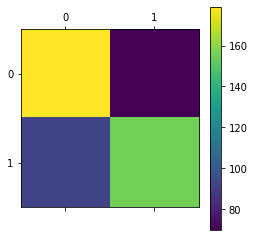

,0,1
0,179,70
1,92,156


In [35]:
SVM_Orb = svm.SVC(kernel = 'rbf')

SVM_Orb.fit(X_train_Orb, y_train_Orb)

y_pred_Orb_SVM = SVM_Orb.predict(X_test_Orb)

print(metrics.classification_report(y_test_Orb, y_pred_Orb_SVM, zero_division = 0))

print("Accuracy Calculado:", metrics.accuracy_score(y_test_Orb, y_pred_Orb_SVM))
print("Accuracy CrossValidation:", cross_val_score(SVM_Orb, X_Orb, y_Orb, cv = kfold, scoring = "accuracy").mean(), "\n")

CM_ORB_SVM = confusion_matrix(y_test_Orb, y_pred_Orb_SVM)
DF_CM_ORB_SVM = pd.DataFrame(data = CM_ORB_SVM)

print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_ORB_SVM)
DF_CM_ORB_SVM

#### **Random Forest** 

Es un algoritmo de clasificación que está basado en árboles de decisiones. Construye de manera aleatoria cada árbol individual para tratar de crear un bosque de árboles no correlacionado cuya predicción es más precisa que la de cualquier árbol individual. 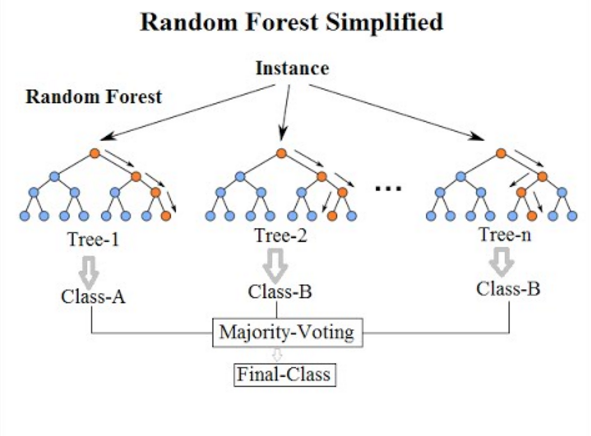

##### SURF

              precision    recall  f1-score   support

         0.0       0.75      0.89      0.81       484
         1.0       0.87      0.72      0.79       509

    accuracy                           0.80       993
   macro avg       0.81      0.80      0.80       993
weighted avg       0.81      0.80      0.80       993

Accuracy Calculado: 0.7995971802618328
Accuracy CrossValidation: 0.7964366557137642 

MATRIZ DE CONFUSIÓN



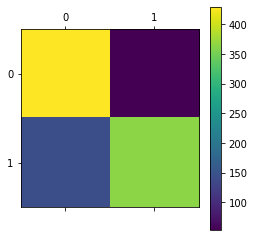

,0,1
0,430,54
1,145,364


In [36]:
RF_Surf = RandomForestClassifier(max_depth=3, random_state=10)
RF_Surf.fit(X_train_Surf, y_train_Surf)

y_pred_Surf_RF = RF_Surf.predict(X_test_Surf)

print(metrics.classification_report(y_test_Surf, y_pred_Surf_RF,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Surf, y_pred_Surf_RF))
print("Accuracy CrossValidation:", cross_val_score(RF_Surf, X_Surf, y_Surf, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SURF_RF = confusion_matrix(y_test_Surf,y_pred_Surf_RF)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SURF_RF)
DF_CM_SURF_RF = pd.DataFrame(data = CM_SURF_RF)
DF_CM_SURF_RF

##### SIFT

              precision    recall  f1-score   support

         0.0       0.78      0.81      0.80       258
         1.0       0.79      0.75      0.77       239

    accuracy                           0.78       497
   macro avg       0.78      0.78      0.78       497
weighted avg       0.78      0.78      0.78       497

Accuracy Calculado: 0.7826961770623743
Accuracy CrossValidation: 0.8032980406474384 

MATRIZ DE CONFUSIÓN



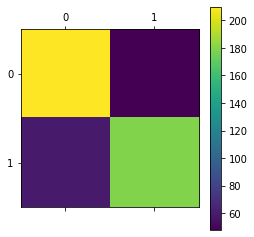

,0,1
0,210,48
1,60,179


In [37]:
RF_Sift = RandomForestClassifier(max_depth=3, random_state=10)
RF_Sift.fit(X_train_Sift, y_train_Sift)

y_pred_Sift_RF = RF_Sift.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_RF,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Sift, y_pred_Sift_RF))
print("Accuracy CrossValidation:", cross_val_score(RF_Sift, X_Sift, y_Sift, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SIFT_RF = confusion_matrix(y_test_Sift,y_pred_Sift_RF)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_RF)
DF_CM_SIFT_RF = pd.DataFrame(data = CM_SIFT_RF)
DF_CM_SIFT_RF

#### **KNeighborsClassifier**

El principio detrás este modelo es encontrar un número predefinido de muestras de entrenamiento más cercanas en distancia al nuevo punto y de esta forma la la clase a partir de ellas. El valor de ***n*** nos indica la cantidad de vecinos que tomaremos en cuenta para la clasificación y la complejidad. 

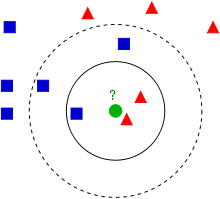

##### SURF

              precision    recall  f1-score   support

         0.0       0.81      0.89      0.84       484
         1.0       0.88      0.80      0.84       509

    accuracy                           0.84       993
   macro avg       0.84      0.84      0.84       993
weighted avg       0.84      0.84      0.84       993

Accuracy Calculado: 0.8408862034239678
Accuracy CrossValidation: 0.8472410855543384 

MATRIZ DE CONFUSIÓN



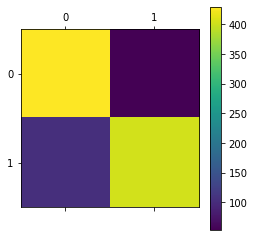

,0,1
0,430,54
1,104,405


In [38]:
KNN_Surf = KNeighborsClassifier(n_neighbors=15)

KNN_Surf.fit(X_train_Surf, y_train_Surf)

y_pred_Surf_KNN = KNN_Surf.predict(X_test_Surf)

print(metrics.classification_report(y_test_Surf, y_pred_Surf_KNN,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Surf, y_pred_Surf_KNN))
print("Accuracy CrossValidation:", cross_val_score(KNN_Surf, X_Surf, y_Surf, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SURF_KNN = confusion_matrix(y_test_Surf,y_pred_Surf_KNN)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SURF_KNN)
DF_CM_SURF_KNN = pd.DataFrame(data = CM_SURF_KNN)
DF_CM_SURF_KNN

##### SIFT

              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85       258
         1.0       0.84      0.83      0.84       239

    accuracy                           0.84       497
   macro avg       0.84      0.84      0.84       497
weighted avg       0.84      0.84      0.84       497

Accuracy Calculado: 0.8430583501006036
Accuracy CrossValidation: 0.8609492515516611 

MATRIZ DE CONFUSIÓN



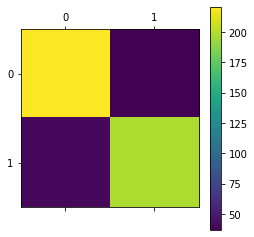

,0,1
0,221,37
1,41,198


In [39]:
KNN_Sift = KNeighborsClassifier(n_neighbors=15)

KNN_Sift.fit(X_train_Sift, y_train_Sift)

y_pred_Sift_KNN = KNN_Sift.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_KNN,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Sift, y_pred_Sift_KNN))
print("Accuracy CrossValidation:", cross_val_score(KNN_Sift, X_Sift, y_Sift, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SIFT_KNN = confusion_matrix(y_test_Sift,y_pred_Sift_KNN)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_KNN)
DF_CM_SIFT_KNN = pd.DataFrame(data = CM_SIFT_KNN)
DF_CM_SIFT_KNN

#### **Multinomial Naive Bayes**

Modelo que mejora el desempeño del Naive Bayes simple. Este modelo considera el número de apariciones del término para evaluar la contribución de la probabilidad condicional dada la clase con lo que el modelado de cada documento se ajusta mejor a la clase a la que pertenece.

##### SURF

              precision    recall  f1-score   support

         0.0       0.70      0.77      0.73       484
         1.0       0.76      0.69      0.72       509

    accuracy                           0.73       993
   macro avg       0.73      0.73      0.73       993
weighted avg       0.73      0.73      0.73       993

Accuracy Calculado: 0.7270896273917422
Accuracy CrossValidation: 0.7259170013386881 

MATRIZ DE CONFUSIÓN



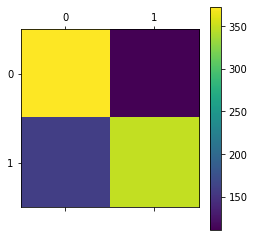

,0,1
0,373,111
1,160,349


In [40]:
MNB_Surf = MultinomialNB(alpha=1)

MNB_Surf.fit(X_train_Surf, y_train_Surf)

y_pred_Surf_MNB = MNB_Surf.predict(X_test_Surf)

print(metrics.classification_report(y_test_Surf, y_pred_Surf_MNB,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Surf, y_pred_Surf_MNB))
print("Accuracy CrossValidation:", cross_val_score(MNB_Surf, X_Surf, y_Surf, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SURF_MNB = confusion_matrix(y_test_Surf,y_pred_Surf_MNB)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SURF_MNB)
DF_CM_SURF_MNB = pd.DataFrame(data = CM_SURF_MNB)
DF_CM_SURF_MNB

##### SIFT

              precision    recall  f1-score   support

         0.0       0.79      0.72      0.75       258
         1.0       0.73      0.79      0.76       239

    accuracy                           0.75       497
   macro avg       0.76      0.76      0.75       497
weighted avg       0.76      0.75      0.75       497

Accuracy Calculado: 0.7545271629778671
Accuracy CrossValidation: 0.7614117074358039 

MATRIZ DE CONFUSIÓN



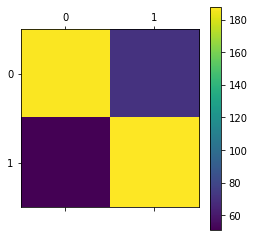

,0,1
0,187,71
1,51,188


In [41]:
MNB_Sift = MultinomialNB(alpha=1)

MNB_Sift.fit(X_train_Sift, y_train_Sift)

y_pred_Sift_MNB = MNB_Sift.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_MNB,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Sift, y_pred_Sift_MNB))
print("Accuracy CrossValidation:", cross_val_score(MNB_Sift, X_Sift, y_Sift, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SIFT_MNB = confusion_matrix(y_test_Sift,y_pred_Sift_MNB)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_MNB)
DF_CM_SIFT_MNB = pd.DataFrame(data = CM_SIFT_MNB)
DF_CM_SIFT_MNB

#### **Gaussian Naive Bayes**

Modelo basado en una distribución continua y que se adecúa de mejor manera para tareas de clasificación más genéricas.

##### SURF

              precision    recall  f1-score   support

         0.0       0.77      0.88      0.82       484
         1.0       0.87      0.75      0.80       509

    accuracy                           0.81       993
   macro avg       0.82      0.81      0.81       993
weighted avg       0.82      0.81      0.81       993

Accuracy Calculado: 0.8116817724068479
Accuracy CrossValidation: 0.7996422051843737 

MATRIZ DE CONFUSIÓN



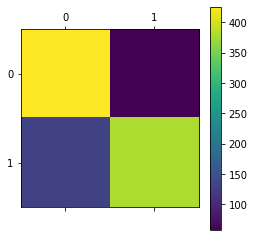

,0,1
0,426,58
1,129,380


In [42]:
GNB_Surf = GaussianNB()

GNB_Surf.fit(X_train_Surf, y_train_Surf)

y_pred_Surf_GNB = GNB_Surf.predict(X_test_Surf)

print(metrics.classification_report(y_test_Surf, y_pred_Surf_GNB,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Surf, y_pred_Surf_GNB))
print("Accuracy CrossValidation:", cross_val_score(GNB_Surf, X_Surf, y_Surf, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SURF_GNB = confusion_matrix(y_test_Surf,y_pred_Surf_GNB)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SURF_GNB)
DF_CM_SURF_GNB = pd.DataFrame(data = CM_SURF_GNB)
DF_CM_SURF_GNB

##### SIFT

              precision    recall  f1-score   support

         0.0       0.75      0.76      0.76       258
         1.0       0.74      0.73      0.74       239

    accuracy                           0.75       497
   macro avg       0.75      0.75      0.75       497
weighted avg       0.75      0.75      0.75       497

Accuracy Calculado: 0.7484909456740443
Accuracy CrossValidation: 0.7783010831203602 

MATRIZ DE CONFUSIÓN



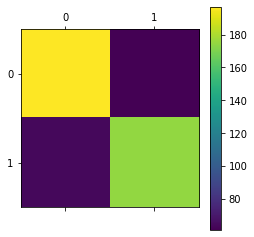

,0,1
0,197,61
1,64,175


In [43]:
GNB_Sift = GaussianNB()

GNB_Sift.fit(X_train_Sift, y_train_Sift)

y_pred_Sift_GNB = GNB_Sift.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_GNB,zero_division=0))

print("Accuracy Calculado:",metrics.accuracy_score(y_test_Sift, y_pred_Sift_GNB))
print("Accuracy CrossValidation:", cross_val_score(GNB_Sift, X_Sift, y_Sift, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SIFT_GNB = confusion_matrix(y_test_Sift,y_pred_Sift_GNB)
print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_GNB)
DF_CM_SIFT_GNB = pd.DataFrame(data = CM_SIFT_GNB)
DF_CM_SIFT_GNB

#### **VotationClassifier**


              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87       258
         1.0       0.88      0.82      0.85       239

    accuracy                           0.86       497
   macro avg       0.87      0.86      0.86       497
weighted avg       0.86      0.86      0.86       497

Accuracy Calculado: 0.8631790744466801
Accuracy CrossValidation: 0.861363027869052 

MATRIZ DE CONFUSIÓN



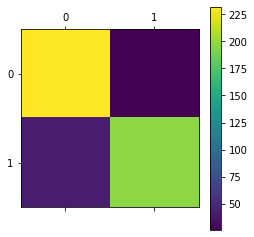

,0,1
0,232,26
1,42,197


In [44]:
estimadores = []
estimadores.append(("Naive Bayes", GaussianNB()))
estimadores.append(("Random Forest", RandomForestClassifier()))
estimadores.append(("SVM",svm.SVC()))

Voting = VotingClassifier(estimadores)

Voting.fit(X_train_Sift,y_train_Sift)

y_pred_Sift_Voting = Voting.predict(X_test_Sift)

print(metrics.classification_report(y_test_Sift, y_pred_Sift_Voting,zero_division=0))
print("Accuracy Calculado:",metrics.accuracy_score(y_test_Sift, y_pred_Sift_Voting))
print("Accuracy CrossValidation:", cross_val_score(Voting, X_Sift, y_Sift, cv=kfold, scoring = "accuracy").mean(),"\n")

CM_SIFT_VOTING = confusion_matrix(y_test_Sift, y_pred_Sift_Voting)

print("MATRIZ DE CONFUSIÓN\n")
showconfusionamtrix(CM_SIFT_VOTING)

DF_CM_SIFT_VOTING = pd.DataFrame(data = CM_SIFT_VOTING)
DF_CM_SIFT_VOTING



### Comparación de resultados

Para el análisis realizamos un gráfico de cajas que permitirá visualizar cada modelo.

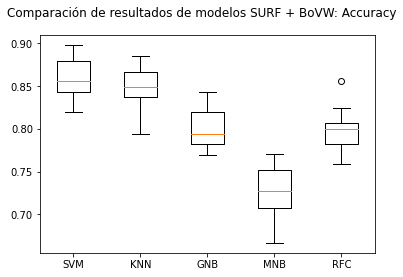

In [45]:
#@title Diagrama de Cajas - SURF
models = []

modelo = Sequential()


models.append(('SVM', SVM_Surf ))
models.append(('KNN', KNN_Surf))
models.append(('GNB', GNB_Surf))
models.append(('MNB', MNB_Surf))
models.append(('RFC', RF_Surf))

results = []
names = []

for name, model in models:
	cv_results = cross_val_score(model, X_Surf, y_Surf, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)


fig = plt.figure()
fig.suptitle('Comparación de resultados de modelos SURF + BoVW: Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

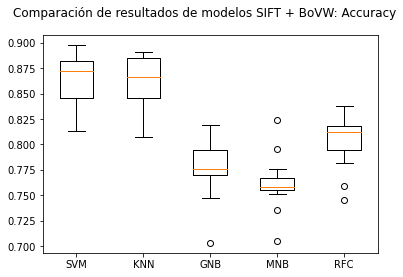

In [46]:
#@title Diagrama de Cajas - SIFT
models = []

modelo = Sequential()


models.append(('SVM', SVM_Sift))
models.append(('KNN', KNN_Sift))
models.append(('GNB', GNB_Sift))
models.append(('MNB', MNB_Sift))
models.append(('RFC', RF_Sift))

results = []
names = []

for name, model in models:
	cv_results = cross_val_score(model, X_Sift, y_Sift, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)


fig = plt.figure()
fig.suptitle('Comparación de resultados de modelos SIFT + BoVW: Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

En general, podemos darnos cuenta que el **accuracy** tanto en SIFT como en SURF no sobrepasan el 50% como media.

En el caso de SURF el mejor modelo respecto al accuracy es el Support Vector Machine con una media del 48%, superior a cualquier otro modelo.

Para SIFT, el modelo que obtuvo un mejor desempeño respecto al accuracy es el Random Forest, el cual obtiene un 46%.

In [47]:
from minisom import MiniSom


X_train_Sift,y_train_Sift

data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values

ModuleNotFoundError: ignored

In [ ]:
sift

In [ ]:
df_sift.iloc[:, :19]